<a href="https://colab.research.google.com/github/Jonaminio/machine_learning/blob/main/Desafio_Classifica%C3%A7%C3%A3o_Simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neste desafio você utilizará tudo que aprendeu na disciplina até aqui.

### Notas
* Formem um grupo para trabalhar no desafio
* Leia o dataset do simpsons que tem 10 personagens:
 * * 'homer_simpson',
 * * 'krusty_the_clown',
  * * 'milhouse_van_houten',
  * * 'moe_szyslak',
  * * 'marge_simpson',
  * * 'charles_montgomery_burns',
  * * 'principal_skinner',
  * * 'lisa_simpson',
  * * 'bart_simpson',
  * * 'maggie_simpson',
  * * 'ned_flanders'
* Crie uma rede neural para fazer a classificação dos personagens.
* Utilize o tuturial do keras como base para fazer seu projeto: https://keras.io/examples/vision/image_classification_from_scratch/


In [ ]:
## Carregar dataset do driver
! gdown --id 10LHQdFBLU_X4Vvdw_a_5foL4LnQKTEPM

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10LHQdFBLU_X4Vvdw_a_5foL4LnQKTEPM
To: /content/dataset.zip
100% 704M/704M [00:06<00:00, 110MB/s] 


In [ ]:
! unzip -qq /content/dataset.zip -d /content/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!ls simpsons_dataset11

bart_simpson		  krusty_the_clown  marge_simpson	 ned_flanders
charles_montgomery_burns  lisa_simpson	    milhouse_van_houten  principal_skinner
homer_simpson		  maggie_simpson    moe_szyslak		 simpsons_dataset11


In [ ]:
! rm -r /content/simpsons_dataset11/simpsons_dataset11

In [ ]:
import os
personagens = os.listdir('simpsons_dataset11')
## Rovendo simpsons_dataset11 de dentro da pasta
#personagens.remove('simpsons_dataset11')
personagens

['principal_skinner',
 'milhouse_van_houten',
 'maggie_simpson',
 'lisa_simpson',
 'homer_simpson',
 'krusty_the_clown',
 'marge_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'moe_szyslak',
 'ned_flanders']

In [ ]:

num_skipped = 0
for folder_name in tuple(personagens):
    folder_path = os.path.join("simpsons_dataset11", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Crie seu projeto a partir daqui..

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "simpsons_dataset11",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
  batch_size=batch_size,
  label_mode='categorical',
)
classes = train_ds.class_names

Found 13939 files belonging to 11 classes.
Using 11152 files for training.
Using 2787 files for validation.


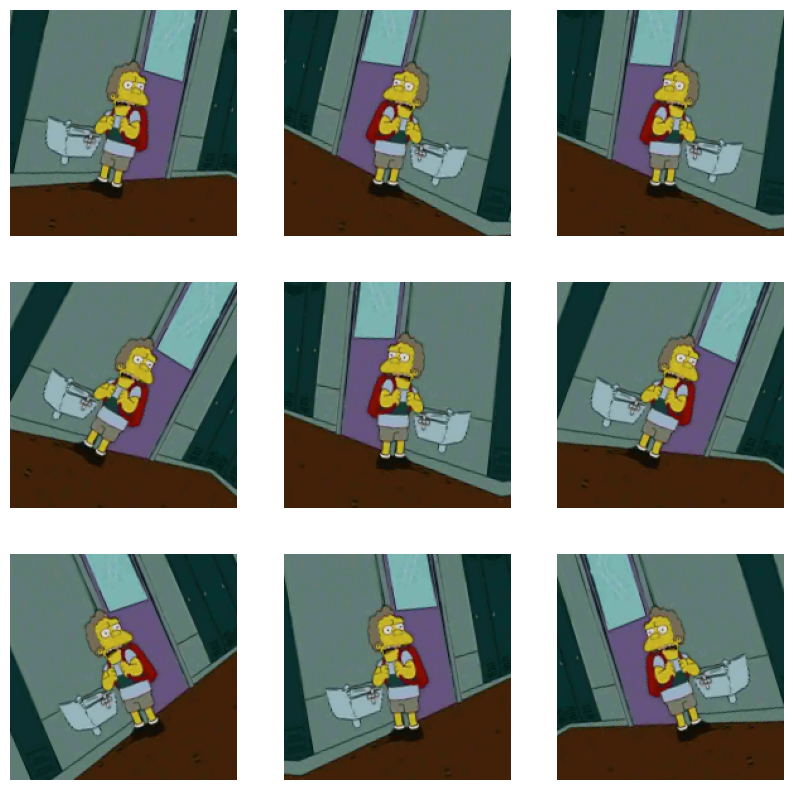

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

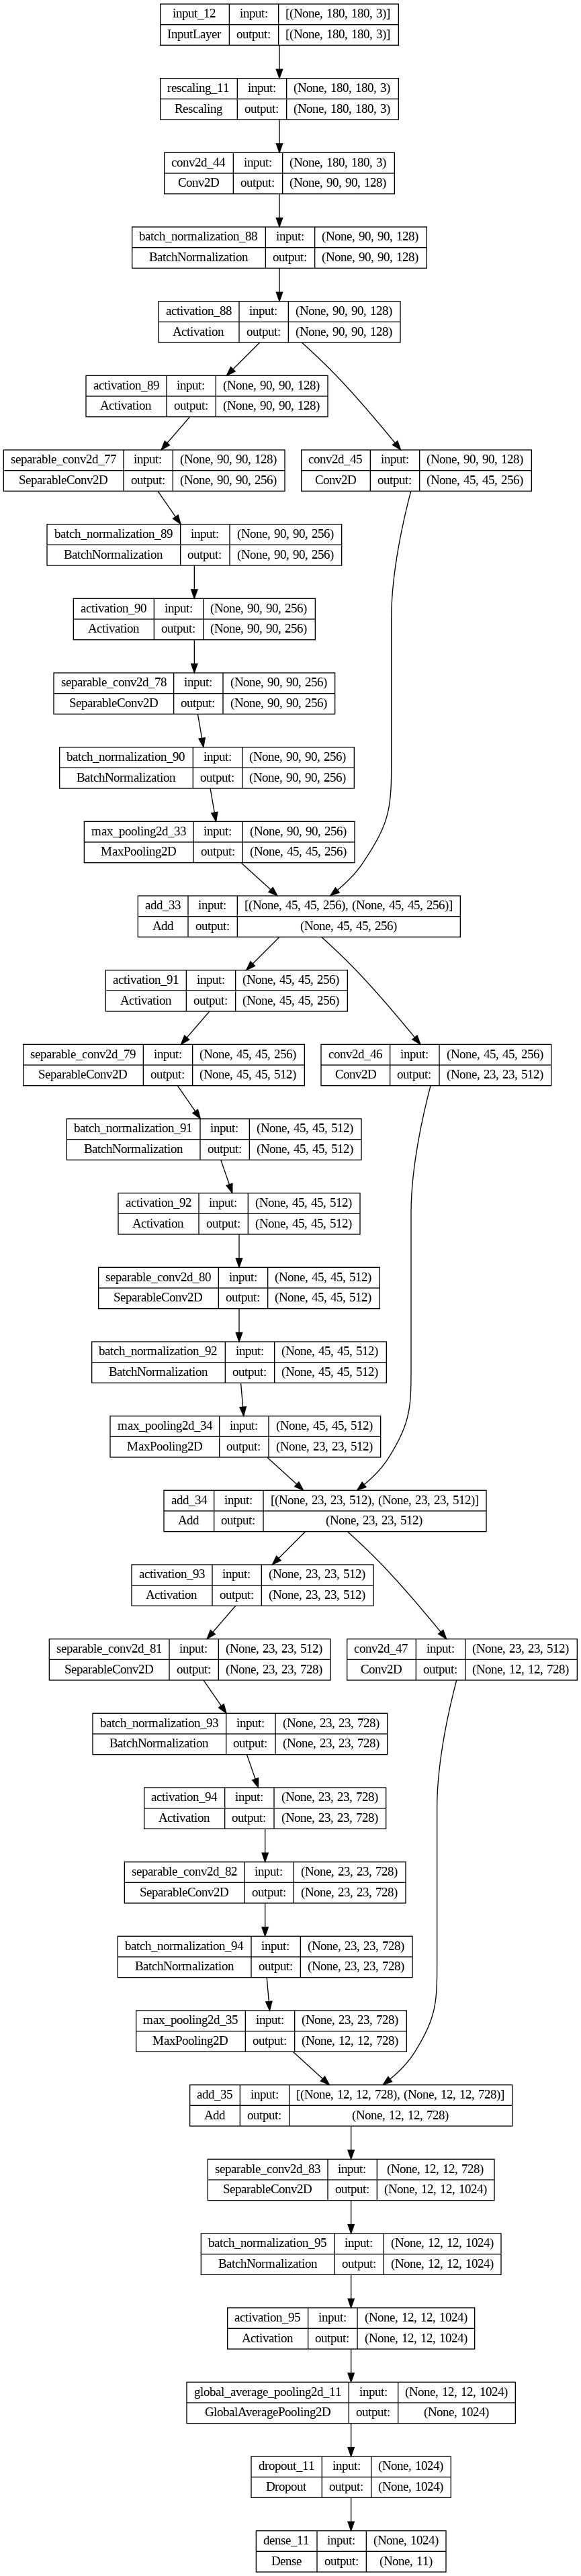

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes


    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]


In [ ]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [ ]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
18/88 [=====>........................] - ETA: 1:27 - loss: 2.2618 - accuracy: 0.2426

KeyboardInterrupt: ignored

## Predicts

In [ ]:
loaded_model = tf.keras.models.load_model("/content/save_at_14.keras")

1/1 [==============================] - 0s 19ms/step
[[0.09308936 0.0931133  0.09199957 0.088174   0.09336255 0.07991505
  0.09183282 0.09193748 0.09104603 0.09245252 0.09307727]]
O personagem da imagem é:  lisa_simpson


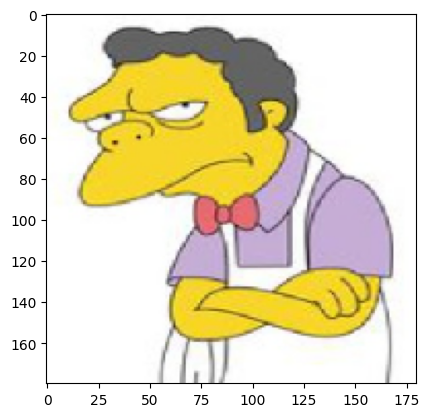

In [ ]:
img = keras.utils.load_img(
    "/content/simpsons_dataset11/moe_szyslak/pic_0004.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = classes[model.predict(img_array).argmax(axis=-1)[0]]
scores = model.predict(img_array)
print(scores)
print("O personagem da imagem é: ", predictions)

In [ ]:
personagens

['principal_skinner',
 'milhouse_van_houten',
 'maggie_simpson',
 'lisa_simpson',
 'homer_simpson',
 'krusty_the_clown',
 'marge_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'moe_szyslak',
 'ned_flanders']

In [ ]:
import pandas as pd
df = pd.DataFrame({"personagens": personagens, "score": scores[0]})

In [ ]:
df.head(11)

,personagens,score
0,principal_skinner,0.093536
1,milhouse_van_houten,0.092984
2,maggie_simpson,0.092384
3,lisa_simpson,0.088313
4,homer_simpson,0.093299
5,krusty_the_clown,0.079915
6,marge_simpson,0.093043
7,bart_simpson,0.092036
8,charles_montgomery_burns,0.090055
9,moe_szyslak,0.091716


<Axes: xlabel='personagens'>

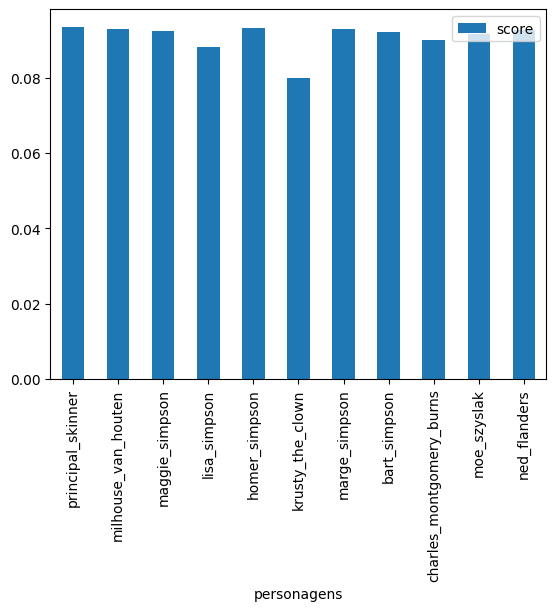

In [ ]:
df.set_index("personagens").plot(kind='bar')

['bart_simpson',
 'charles_montgomery_burns',
 'homer_simpson',
 'krusty_the_clown',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'milhouse_van_houten',
 'moe_szyslak',
 'ned_flanders',
 'principal_skinner']